**SMS Spam Classification Dataset from the UCI Repository is uploaded and zip and unzipped here to make it sit in folders for process**

In [ ]:
! unzip /content/smsspamcollection.zip

Archive:  /content/smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


**Import necessary Packages**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
%matplotlib inline

**Read the data using pandas framework with column names label and message**

In [ ]:
dataset = pd.read_csv('/content/SMSSpamCollection',sep='\t',names=['label','message'])

Display first five rows from the dataset

In [ ]:
dataset.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Based on the labels, the number of ham & spam messages are counted and plotted**

In [ ]:
dataset.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [ ]:
dataset.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

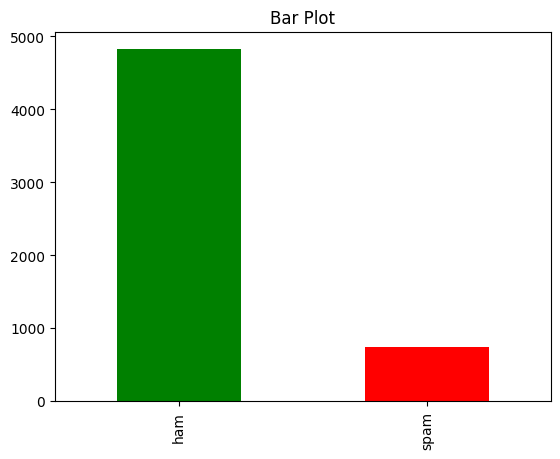

In [ ]:
count_Class=pd.value_counts(dataset["label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show()

**Now the labels are given a numeric value 0 & 1.**

**SPAM : 1**

**HAM : 0**

In [ ]:
dataset['label'] = dataset['label'].map( {'spam': 1, 'ham': 0} )

In [ ]:
dataset.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**Put different Labels in separate pandas dataframe inorder to generate WORDCLOUD**

In [ ]:
data_ham  = dataset[dataset['label'] == 0].copy()
data_spam = dataset[dataset['label'] == 1].copy()

In [ ]:
import wordcloud
from wordcloud import WordCloud
def show_wordcloud(df, title):
    text = ' '.join(df['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

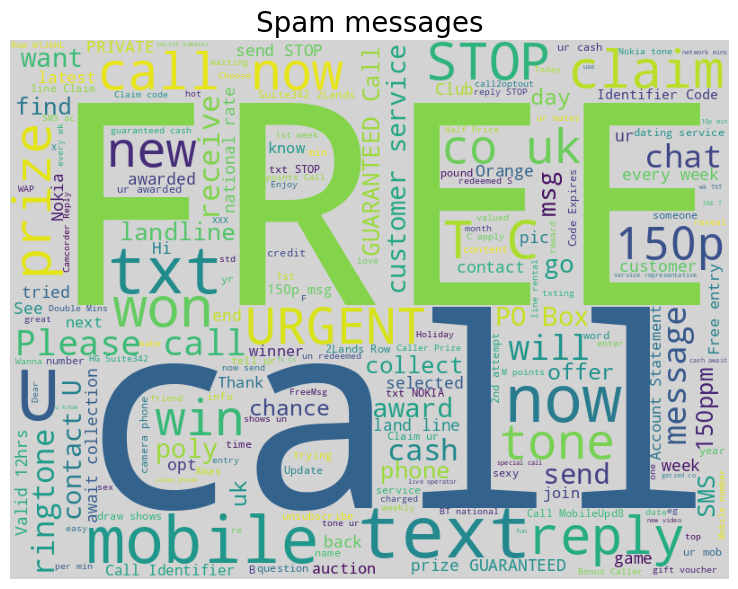

In [ ]:
show_wordcloud(data_spam, "Spam messages")

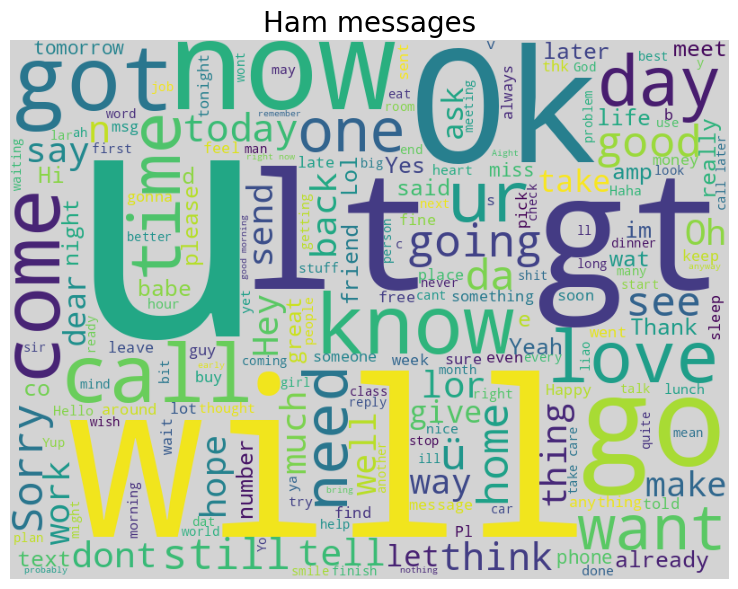

In [ ]:
show_wordcloud(data_ham, "Ham messages")

**Import Necessary for text preprocessing & Training**

In [ ]:
# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split

**Dataset split into Train & Test**

In [ ]:
X = dataset['message'].values
y = dataset['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**Text Pre-Processing**

**1. Tokenization**

**2. Text Encoding**

**3. Padding**

In [ ]:
t = Tokenizer()
t.fit_on_texts(X_train)

In [ ]:
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[87, 2, 172, 485, 461, 121, 33, 5, 3857, 3858, 315, 1268, 30, 2603, 67, 82, 2, 1657, 2, 316, 238], [246, 873, 15, 54, 8, 462, 160, 21, 25, 95, 1658, 77, 1, 61, 1120, 3859, 33, 174, 3, 53, 2604]]


In [ ]:
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_train)

[[2603   67   82 ...    2  316  238]
 [  61 1120 3859 ...    3   53 2604]
 [  49   85   97 ...    6  247   99]
 ...
 [1640   31 2485 ...  254   31 2486]
 [ 944 1460 1197 ...    0    0    0]
 [ 116   74   37 ...    9 3219 1396]]


**Model is Built with vocabulary size as the input size.** 

**Model is compiled and summary generated**

In [ ]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(SimpleRNN(24, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 24)             190896    
                                                                 
 simple_rnn (SimpleRNN)      (None, 24)                1176      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 192,097
Trainable params: 192,097
Non-trainable params: 0
_________________________________________________________________
None


**Model is trained and validated for test dataset with 50 epochs.**

**Callback is made at an early stage when the validation loss has its first minimum value.**

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train,
         y=y_train,
         epochs=100,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Epoch 1/100
140/140 [==============================] - 4s 9ms/step - loss: 0.2361 - accuracy: 0.9134 - val_loss: 0.1092 - val_accuracy: 0.9650
Epoch 2/100
140/140 [==============================] - 1s 6ms/step - loss: 0.0726 - accuracy: 0.9794 - val_loss: 0.0862 - val_accuracy: 0.9713
Epoch 3/100
140/140 [==============================] - 1s 7ms/step - loss: 0.0458 - accuracy: 0.9865 - val_loss: 0.0655 - val_accuracy: 0.9821
Epoch 4/100
140/140 [==============================] - 1s 6ms/step - loss: 0.0349 - accuracy: 0.9912 - val_loss: 0.0774 - val_accuracy: 0.9767
Epoch 5/100
140/140 [==============================] - 1s 7ms/step - loss: 0.0256 - accuracy: 0.9928 - val_loss: 0.0691 - val_accuracy: 0.9803
Epoch 6/100
140/140 [==============================] - 1s 6ms/step - loss: 0.0185 - accuracy: 0.9962 - val_loss: 0.0844 - val_accuracy: 0.9758
Epoch 7/100
140/140 [==============================] - 1s 7ms/step - loss: 0.0159 - accuracy: 0.9964 - val_loss: 0.0747 - val_accuracy: 0.9758

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

**Model Predicted for test dataset.**

**Classification report and Confusion Matrix generated** 

In [ ]:
preds = (model.predict(padded_test) > 0.5).astype("int32")

35/35 [==============================] - 0s 2ms/step


In [ ]:
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       966
           1       0.86      0.89      0.87       149

    accuracy                           0.97      1115
   macro avg       0.92      0.93      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy : 0.9659192825112107


0.9659192825112107

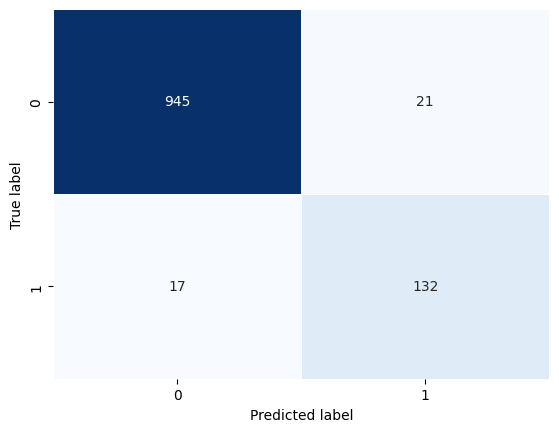

In [ ]:
plot_confusion_matrix(y_test, preds)

**Save the model and the tokenizer (picle package helps us to save the tokenizer to use it on new messages)**

In [ ]:
model.save("spam_model")

In [ ]:
import pickle
with open('spam_model/tokenizer.pkl', 'wb') as output:
   pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

**Load the model and the tokenizer and predict whether the new message is a spam / ham.**

In [ ]:
import tensorflow as tf

s_model = tf.keras.models.load_model("spam_model")
with open('spam_model/tokenizer.pkl', 'rb') as input:
    tokenizer = pickle.load(input)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

sms = ["Lottery won. You are given a free credit card offer with no emi for first month. call 7654437862 to claim your offer"]
#sms = ["hello! how are you? im visiting mom next week"]
sms_proc = t.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
pred = (model.predict(sms_proc)>0.5).astype("int32").item()
print(pred)

1/1 [==============================] - 0s 38ms/step
1


In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
# load SMS spam dataset
data = pd.read_csv('/content/SMSSpamCollection', encoding='latin-1',sep='\t',names=['label','message'])
# drop unnecessary columns
#data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
# rename columns
data = data.rename(columns={'v1': 'label', 'v2': 'message'})
# map labels to binary
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size=0.2)

# tokenize text and create sequences
max_words = 1000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
# pad sequences with zeros
X_train_seq = pad_sequences(sequences, maxlen=max_len)

# tokenize test data and create sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_seq = pad_sequences(test_sequences, maxlen=max_len)

# define RNN model
def create_rnn_model():
    model = Sequential()
    model.add(Embedding(max_words, 32, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create oversampled data
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train_seq, y_train)

# fit oversampled data to RNN model
rnn_model_oversample = create_rnn_model()
rnn_model_oversample.fit(X_train_oversampled, y_train_oversampled, validation_data=(X_test_seq, y_test), epochs=10, batch_size=64)

# create undersampled data
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_undersampled, y_train_undersampled = undersample.fit_resample(X_train_seq, y_train)

# fit undersampled data to RNN model
rnn_model_undersample = create_rnn_model()
rnn_model_undersample.fit(X_train_undersampled, y_train_undersampled, validation_data=(X_test_seq, y_test), epochs=10, batch_size=64)

# create SMOTE data
smote = SMOTE(sampling_strategy='minority')
X_train_smote, y_train_smote = smote.fit_resample(X_train_seq, y_train)

# fit SMOTE data to RNN model
rnn_model_smote = create_rnn_model()
rnn_model_smote.fit(X_train_smote, y_train_smote, validation_data=(X_test_seq, y_test), epochs=10, batch_size=64)

Epoch 1/10
121/121 [==============================] - 57s 437ms/step - loss: 0.3395 - accuracy: 0.8601 - val_loss: 0.0920 - val_accuracy: 0.9758
Epoch 2/10
121/121 [==============================] - 48s 393ms/step - loss: 0.0578 - accuracy: 0.9828 - val_loss: 0.0613 - val_accuracy: 0.9848
Epoch 3/10
121/121 [==============================] - 49s 399ms/step - loss: 0.0285 - accuracy: 0.9930 - val_loss: 0.0775 - val_accuracy: 0.9722
Epoch 4/10
121/121 [==============================] - 49s 403ms/step - loss: 0.0184 - accuracy: 0.9953 - val_loss: 0.0736 - val_accuracy: 0.9839
Epoch 5/10
121/121 [==============================] - 49s 402ms/step - loss: 0.0123 - accuracy: 0.9975 - val_loss: 0.0795 - val_accuracy: 0.9839
Epoch 6/10
121/121 [==============================] - 49s 403ms/step - loss: 0.0117 - accuracy: 0.9969 - val_loss: 0.0886 - val_accuracy: 0.9758
Epoch 7/10
121/121 [==============================] - 49s 408ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.0914 - val_ac

The sms "we offer a free loan. Call 9998846756 to avail the free loan" is predicted as spam with label 1. This is done based on the common words seen in spam wordcloud like offer, free, call. The Prediction accuracy is 98.3% as in classification report generated. 

# ***THANK YOU***
